# Gaussian Mixture Model with ADVI


##### Keywords: mixture model, gaussian mixture model, normal distribution, ADVI, marginal, marginalizing over discretes, ELBO

This notebook is taken almost verbatim from the pymc3 documentation (https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html) . Its a very good illustration of what needs to be done to

- marginalize over discretes for ADVI
- deal with 2D mixtures
- get MCMC done as well with a custom density

Thus it provides an illustration of many concepts that will come useful.

In [1]:
%matplotlib inline

import theano
theano.config.floatX = 'float64'

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Generate some data

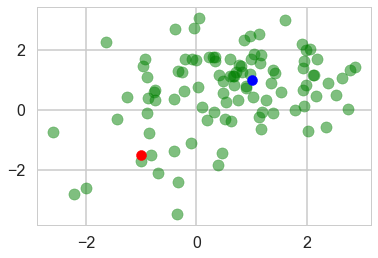

In [2]:
n_samples = 100
# we can use this to set up the pseodorandom number appropriately to communicate results reliably
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]])
ps = np.array([0.2, 0.8])

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

In [3]:
zs[0,:].mean(), zs[1,:].mean()

(0.13, 0.87)

## Marginalize discretes

Gaussian mixture models are usually constructed with categorical random variables. However, any discrete rvs does not fit ADVI. Here, class assignment variables are marginalized out, giving weighted sum of the probability for the gaussian components. The log likelihood of the total probability is calculated using logsumexp, which is a standard technique for making this kind of calculation stable. 

In the below code, DensityDist class is used as the likelihood term. The second argument, logp_gmix(mus, pi, np.eye(2)), is a python function which recieves observations (denoted by 'value') and returns the tensor representation of the log-likelihood. 

In [4]:
from pymc3.math import logsumexp

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):        
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]
            
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

## Sampling

In [5]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=np.zeros(2), tau=np.eye(2), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=0.1 * np.ones(2), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

For comparison with ADVI, run MCMC. 

In [12]:
with model:
    #trace = pm.sample(5000, chains=2, njobs=1)
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start, chains=2, njobs=1)

logp = -379.73, ||grad|| = 62.173: 100%|██████████| 4/4 [00:00<00:00, 396.47it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pi_stickbreaking__]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
100%|██████████| 1500/1500 [00:01<00:00, 887.69it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_0__0,0.815877,0.110761,0.006549,0.627866,1.048859,231.0,1.000956
mu_0__1,1.003558,0.107124,0.006556,0.768440,1.196505,189.0,1.014715
mu_1__0,-0.788941,0.311106,0.018186,-1.326879,-0.151145,209.0,0.999517
mu_1__1,-1.448982,0.348317,0.022775,-2.160589,-0.838788,112.0,1.001408
pi__0,0.858311,0.044657,0.002409,0.775095,0.942094,170.0,1.000205
pi__1,0.141689,0.044657,0.002409,0.057906,0.224905,170.0,1.000205


Check posterior of component means and weights. We can see that the MCMC samples of the component mean for the lower-left component varied more than the upper-right due to the difference of the sample size of these clusters. 

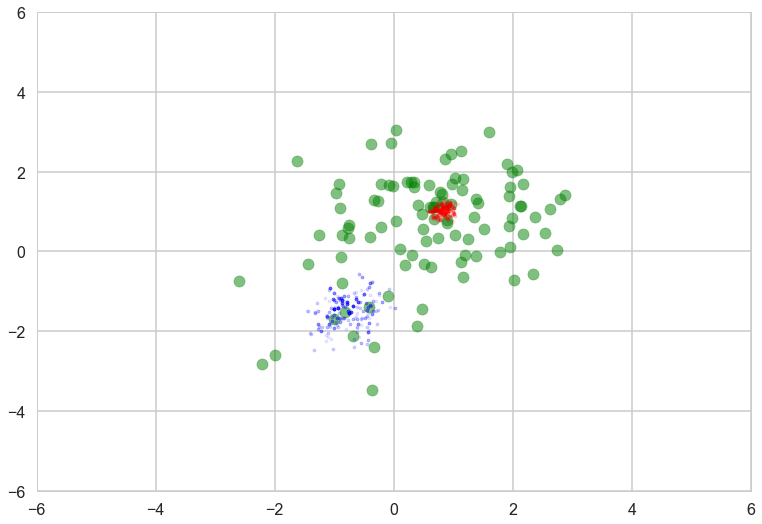

In [14]:
with sns.plotting_context('poster'):
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
    mu_0, mu_1 = trace['mu_0'], trace['mu_1']
    plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10, alpha=0.1)
    plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10, alpha=0.1)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

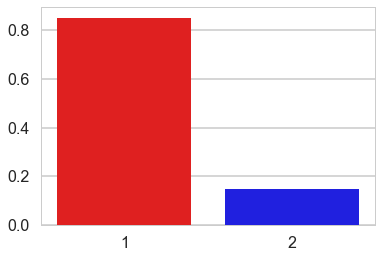

In [15]:
sns.barplot([1, 2], np.mean(trace['pi'][-500:], axis=0), 
            palette=['red', 'blue'])

We can use the same model with ADVI as follows. 

In [17]:
# with pm.Model() as model:
#     mus = [MvNormal('mu_%d' % i, mu=np.zeros(2), tau=np.eye(2), shape=(2,))
#            for i in range(2)]
#     pi = Dirichlet('pi', a=0.1 * np.ones(2), shape=(2,))
#     xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    
approx = pm.fit(model=model, n=5000)

Average Loss = 348.58: 100%|██████████| 5000/5000 [00:05<00:00, 845.47it/s]
Finished [100%]: Average Loss = 348.48


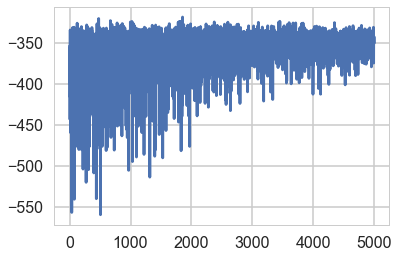

In [18]:
elbo = -approx.hist
plt.plot(elbo)

In [23]:
approx = pm.fit(model=model, n=5000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 321.62: 100%|██████████| 5000/5000 [00:05<00:00, 861.91it/s]
Finished [100%]: Average Loss = 321.62


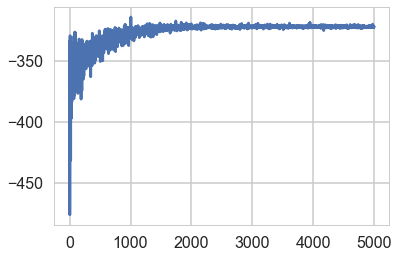

In [24]:
elbo = -approx.hist
plt.plot(elbo)

In [25]:
type(approx)

pymc3.variational.approximations.MeanField

In [42]:
means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)
sds2 = approx.bij.rmap(approx.std.eval())
approx.std.eval()

array([ 0.33675603,  0.28764002,  0.32206536,  0.11278951,  0.11620921])

In [41]:
means, sds, cov, sds2

({'mu_0': array([ 0.8211505 ,  0.98282181]),
  'mu_1': array([-0.79336909, -1.48984231]),
  'pi_stickbreaking__': array([ 1.86297103])},
 {'mu_0': array([ 0.11278951,  0.11620921]),
  'mu_1': array([ 0.28764002,  0.32206536]),
  'pi_stickbreaking__': array([ 0.33675603])},
 array([[ 0.11340462,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.08273678,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.1037261 ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.01272147,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01350458]]),
 {'mu_0': array([ 0.11278951,  0.11620921]),
  'mu_1': array([ 0.28764002,  0.32206536]),
  'pi_stickbreaking__': array([ 0.33675603])})

'means' and 'sds' are the mean and standard deviations of the variational posterior. Note that these values are in the transformed space, not in the original space. For random variables in the real line, e.g., means of the Gaussian components, no transformation is applied. Then we can see the variational posterior in the original space. 

In [46]:
mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']
mu_0

array([ 0.8211505 ,  0.98282181])

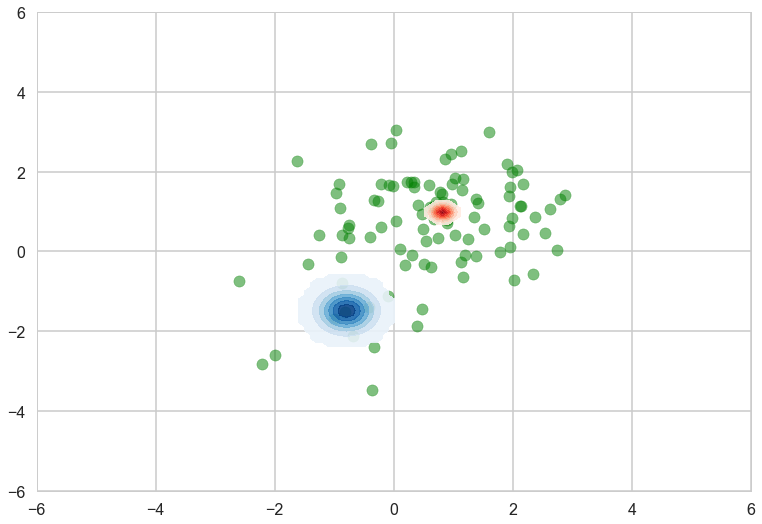

In [47]:
from copy import deepcopy



def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):    
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)
           
with sns.plotting_context('poster'):
    fig, ax = plt.subplots()
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
    plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
    plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

In [48]:
model.vars, means

([mu_0, mu_1, pi_stickbreaking__],
 {'mu_0': array([ 0.8211505 ,  0.98282181]),
  'mu_1': array([-0.79336909, -1.48984231]),
  'pi_stickbreaking__': array([ 1.86297103])})

We need to backward-transform 'pi', which is transformed by 'stick_breaking'. Variables that are transformed are not transformed back by the current pymc3 implementation. This is a gotcha to keep in mind. See https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/transforms.py#L200 for details

In [50]:
model.pi_stickbreaking__

pi_stickbreaking__

In [51]:
from pymc3.distributions.transforms import StickBreaking
trans = StickBreaking()
trans.backward(means['pi_stickbreaking__']).eval()

array([ 0.86564287,  0.13435713])

To demonstrate that ADVI works for large dataset with mini-batch, let's create 100,000 samples from the same mixture distribution. 

(-6, 6)

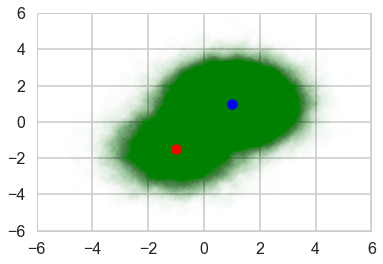

In [54]:
n_samples = 100000

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.008)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

MCMC takes of ther order of a minute in time, which is 50 times more than on the small dataset.

In [56]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=np.zeros(2), tau=np.eye(2), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=0.1 * np.ones(2), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start, chains=2, njobs=1)

logp = -3.9604e+05, ||grad|| = 55,408: 100%|██████████| 4/4 [00:00<00:00, 29.37it/s]   
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [pi_stickbreaking__]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
100%|██████████| 1500/1500 [02:00<00:00, 12.49it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Posterior samples are concentrated on the true means, so looks like single point for each component. 

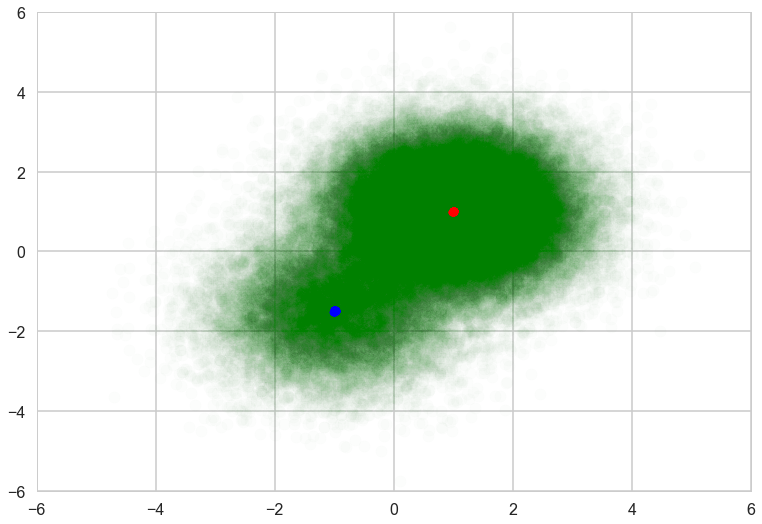

In [59]:
with sns.plotting_context('poster'):
    plt.scatter(data[:, 0], data[:, 1], alpha=0.01, c='g')
    mu_0, mu_1 = trace['mu_0'], trace['mu_1']
    plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=50)
    plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=50)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

For ADVI with mini-batch, put theano tensor on the observed variable of the ObservedRV. The tensor will be replaced with mini-batches. Because of the difference of the size of mini-batch and whole samples, the log-likelihood term should be appropriately scaled. To tell the log-likelihood term, we need to give ObservedRV objects ('minibatch_RVs' below) where mini-batch is put. Also we should keep the tensor ('minibatch_tensors'). 

In [60]:
minibatch_size = 200
# In memory Minibatches for better speed
data_t = pm.Minibatch(data, minibatch_size)

with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=np.zeros(2), tau=0.1 * np.eye(2), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=0.1 * np.ones(2), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data_t)

Run ADVI. It's much faster than MCMC, though the problem here is simple and it's not a fair comparison. 

In [61]:
# Used only to write the function call in single line for using %time
# is there more smart way?
def f():
    approx = pm.fit(n=1500, obj_optimizer=pm.adagrad(learning_rate=1e-1), model=model)
    means = approx.bij.rmap(approx.mean.eval())
    sds = approx.bij.rmap(approx.std.eval())
    return means, sds, -approx.hist

means, sds, elbos = f()

Average Loss = 667.16: 100%|██████████| 1500/1500 [00:01<00:00, 823.18it/s]
Finished [100%]: Average Loss = 667.05


The result is almost the same. 

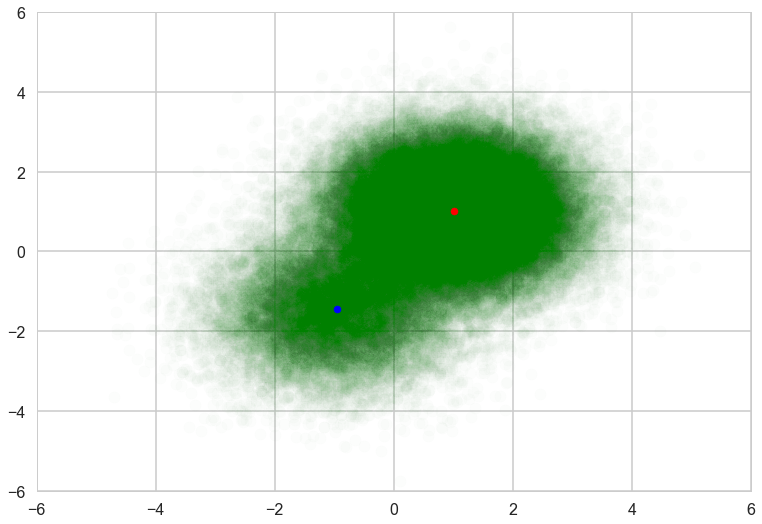

In [64]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']
with sns.plotting_context('poster'):
    fig, ax = plt.subplots()
    plt.scatter(data[:, 0], data[:, 1], alpha=0.01, c='g')
    plt.scatter(mu_0[0], mu_0[1], c="r", s=50)
    plt.scatter(mu_1[0], mu_1[1], c="b", s=50)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

The variance of the trace of ELBO is larger than without mini-batch because of the subsampling from the whole samples. 

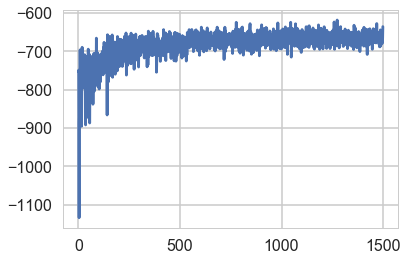

In [65]:
plt.plot(elbos);